<a href="https://colab.research.google.com/github/VatsalyaDubey16/Transfer_Learning_Models/blob/main/Transfer_Leraning_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np

import PIL.Image as Image
import matplotlib.pylab as plt

import tensorflow_hub as hub
import datetime

%load_ext tensorboard


# An image Classifier

* Using a classifier model pre-trained on the ImageNet benchmark dataset-no initial training required!

# Download the classifier
* Select [MobileNetV2](https://arxiv.org/abs/1801.04381) pre-trained model from Tensorflow Hub and wrap it as a Keras layer with `hub.KerasLayer`



In [2]:
mobilenet_v2 ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"
inception_v3 = "https://tfhub.dev/google/imagenet/inception_v3/classification/5"

classifier_model = mobilenet_v2

In [3]:
import tensorflow as tf
import tensorflow_hub as hub

IMAGE_SHAPE = (224, 224)
classifier_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"

classifier = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: hub.KerasLayer(classifier_model)(x),
                           input_shape=IMAGE_SHAPE+(3,))
])


C:\Users\vatsa\anaconda3\Lib\site-packages\keras\src\layers\core\lambda_layer.py:67: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


# Run it on a single image
Download a single image to try the model on:

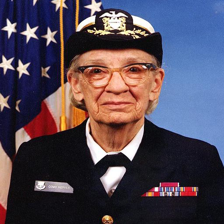

In [5]:
grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)
grace_hopper

In [6]:
grace_hopper = np.array(grace_hopper)/255.
grace_hopper.shape

(224, 224, 3)

In [7]:
result = classifier.predict(grace_hopper[np.newaxis, ...])
result.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


(1, 1001)

In [8]:
predicted_class = tf.math.argmax(result[0], axis =-1)
predicted_class

<tf.Tensor: shape=(), dtype=int64, numpy=653>

In [9]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

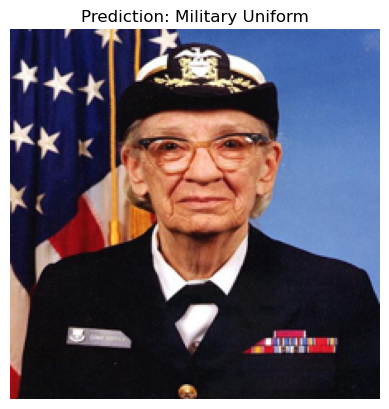

In [10]:
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

# Simple Transfer Learning

But what if you want to create a custom classifier using your own dataset that has classes that aren't included in the original ImageNet dataset (that the pre-trained model was trained on)?

To do that, you can:

  1.Select a pre-trained model from TensorFlow Hub; and
  
  2.Retrain the top (last) layer to recognize the classes from your custom dataset.

## Dataset

In [11]:
# In this example, we will use Tensorflow flowers dataset
import pathlib

data_file = tf.keras.utils.get_file(
    'flower_photos.tgz',
  'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
  cache_dir='.',
   extract=True
)

data_root = pathlib.Path(data_file).with_suffix('')

In [12]:
import os

for dirpath, dirnames, filenames in os.walk(data_root):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")


There are 5 directories and 1 images in 'datasets\flower_photos'.
There are 0 directories and 633 images in 'datasets\flower_photos\daisy'.
There are 0 directories and 898 images in 'datasets\flower_photos\dandelion'.
There are 0 directories and 641 images in 'datasets\flower_photos\roses'.
There are 0 directories and 699 images in 'datasets\flower_photos\sunflowers'.
There are 0 directories and 799 images in 'datasets\flower_photos\tulips'.


In [13]:
batch_size = 32
img_height = 224
img_width = 224

train_ds = tf.keras.utils.image_dataset_from_directory(
  str(data_root),
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
  str(data_root),
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [14]:
# The Flowers dataset has give classes:
class_names = np.array(train_ds.class_names)
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


In [15]:
normalization_layer = tf.keras.layers.Rescaling(1/255.)
# Where x-images, y-labels
train_ds = train_ds.map(lambda x,y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x,y: (normalization_layer(x), y))

In [16]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [17]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


## Run the classifier on a batch of images

In [18]:
# Run the classifier on an image batch:
result_batch = classifier.predict(train_ds)

92/92 ━━━━━━━━━━━━━━━━━━━━ 69s 657ms/step


In [19]:
predicted_class_names = imagenet_labels[tf.math.argmax(result_batch, axis= -1)]
predicted_class_names

array(['daisy', 'buckeye', 'sunscreen', ..., 'daisy', 'hair slide',
       'fire screen'], dtype='<U30')

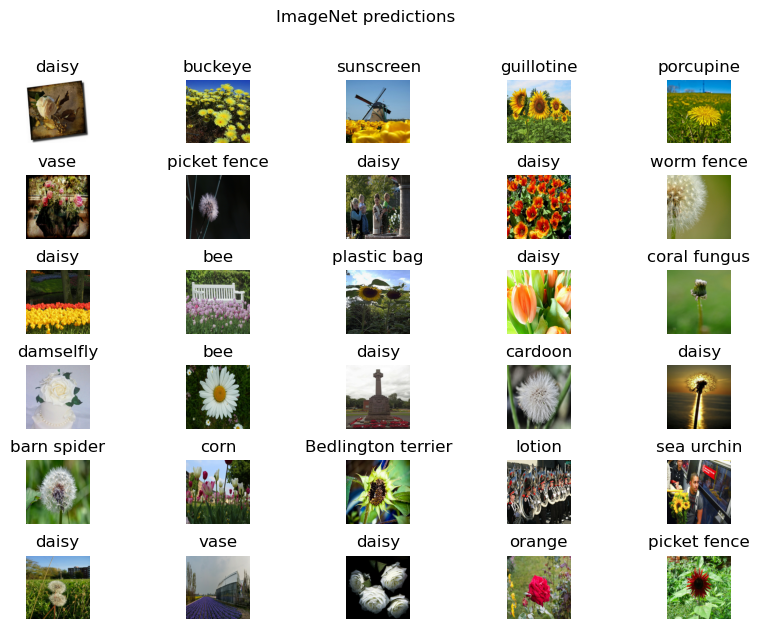

In [20]:
plt.figure(figsize= (10,7))
plt.subplots_adjust(hspace = 0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
  plt.suptitle('ImageNet predictions')

The results are far from perfect, but reasonable considering that these are not the classes the model was trained for (except for "daisy").

## Download the headless model

In [21]:
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
inception_v3 = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"

feature_extractor_model = mobilenet_v2

In [22]:
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape =(224,224,3),
    trainable =False
)

In [23]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


In [24]:
num_classes = len(class_names)

model = tf.keras.Sequential([
     tf.keras.layers.Lambda(lambda x: hub.KerasLayer(feature_extractor_layer)(x),
                           input_shape=IMAGE_SHAPE+(3,)),
    tf.keras.layers.Dense(num_classes)
])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lambda_1 (Lambda)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 5)                   │           6,405 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,405 (25.02 KB)

 Trainable params: 6,405 (25.02 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
predictions = model(image_batch)

In [26]:
predictions.shape

TensorShape([32, 5])

In [27]:
# Train the model
model.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    metrics = ['acc']
)

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%h%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir = log_dir,
    histogram_freq = 1 # Enable histogram computation for every epoch
)

In [28]:
history = model.fit(train_ds,
                    validation_data = val_ds,
                    epochs= 5,
                    callbacks = tensorboard_callback)

Epoch 1/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 88s 763ms/step - acc: 0.5859 - loss: 1.0977 - val_acc: 0.8597 - val_loss: 0.4325
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 47s 509ms/step - acc: 0.8641 - loss: 0.3845 - val_acc: 0.8842 - val_loss: 0.3512
Epoch 3/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 33s 356ms/step - acc: 0.9048 - loss: 0.2917 - val_acc: 0.8910 - val_loss: 0.3215
Epoch 4/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 33s 356ms/step - acc: 0.9294 - loss: 0.2397 - val_acc: 0.8951 - val_loss: 0.3065
Epoch 5/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 32s 352ms/step - acc: 0.9489 - loss: 0.2038 - val_acc: 0.8992 - val_loss: 0.2970


In [32]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 7472), started 0:16:50 ago. (Use '!kill 7472' to kill it.)

In [33]:
predicted_batch = model.predict(image_batch)
predicted_id = tf.math.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]
print(predicted_label_batch)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
['roses' 'dandelion' 'tulips' 'sunflowers' 'dandelion' 'roses' 'dandelion'
 'roses' 'tulips' 'dandelion' 'tulips' 'tulips' 'sunflowers' 'tulips'
 'dandelion' 'roses' 'daisy' 'tulips' 'dandelion' 'dandelion' 'dandelion'
 'tulips' 'sunflowers' 'roses' 'sunflowers' 'dandelion' 'tulips' 'roses'
 'roses' 'sunflowers' 'tulips' 'sunflowers']


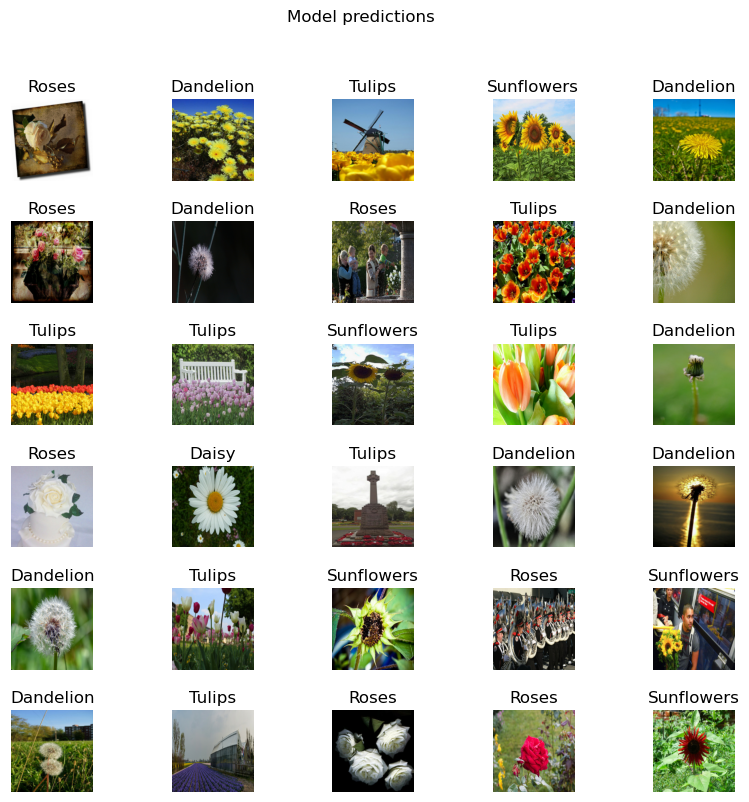

In [34]:
# Plot model predictions:
plt.figure(figsize = (10,9))
plt.subplots_adjust(hspace =0.5)

for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_label_batch[n].title())
  plt.axis('off')
  plt.suptitle("Model predictions")